In [2]:
# this notebook is trying to see what it takes to run the full model 
# (two lithologies, width-dependent transport, lateral sediment, etc.)
# to steady state, albeit on a downsized grid

In [3]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

In [4]:
# testing how to append new values to a 2D array

array = np.zeros((2, 4))

print(array) # whole array
print(array[0]) # 0th row of array

# something with the same length as the number of columns in array
# we'll use this to fill our array
fillers = np.zeros(4)

# this seems to work
# newest values occupy the top row, and older values become the second (and last) row
for i in range (6):
    fillers[:] += 1
    array = np.vstack([fillers, array])
    array = np.delete(array, obj = 2, axis = 0)
    
    print("time", i, array)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[0. 0. 0. 0.]
time 0 [[1. 1. 1. 1.]
 [0. 0. 0. 0.]]
time 1 [[2. 2. 2. 2.]
 [1. 1. 1. 1.]]
time 2 [[3. 3. 3. 3.]
 [2. 2. 2. 2.]]
time 3 [[4. 4. 4. 4.]
 [3. 3. 3. 3.]]
time 4 [[5. 5. 5. 5.]
 [4. 4. 4. 4.]]
time 5 [[6. 6. 6. 6.]
 [5. 5. 5. 5.]]


In [5]:
# define parameters

dx = 1000 # grid spacing
x = np.arange(0, 10000, dx) # domain length
r = 10. # runoff rate
kh = 1/3 # hack coefficient
h = 2 # hack exponent
Hstar = 0.5 # characteristic sediment thickness
beta = np.zeros(len(x))
beta[:3] = 0.0004
beta[3:] = 0.004
# beta = 0.00004 # igneous abrasion coefficient
psi = 0.00004 # attrition factor
K = np.zeros(len(x))
K[:3] = 0.000001
K[3:] = 0.00001
# K = 0.0001 # rock erodibility
# gamma = 0.5 # fraction of coarse sediment from hillslope erosion
gamma = np.zeros(len(x))
gamma[:3] = 0.5
kxb = 25 # valley width coefficient
Pxb = 1/5 # valley width exponent
kb = 8.3e-8 # channel width coefficient
phi = 0.55 # sediment porosity
D = 0.05 # grain size
baselevel_rate = 0.00005

In [6]:
# set up arrays

H = Hstar + np.zeros(len(x)) # sediment thickness
etab = np.zeros(len(x)) # bedrock elevation array
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
eta = etab + H # total topographic elevation

In [7]:
# calculate constant, derivative values

B = kxb * (x**Pxb) # valley width
# Q = r * kh * (x**h) # total discharge
Q = r * B * x

In [8]:
def model(x,
          dx,
          Hstar,
          H,
          etab,
          eta,
          beta,
          psi,
          K,
          gamma,
          kxb,
          Pxb,
          kb,
          phi,
          D,
          baselevel_rate,
          Q,
          B,
          num_steps = 2):
    
    # define more constants
    kqs = 0.041 # sediment discharge coefficient
    I = 0.01 # intermittency factor
    
    # calculate timestep
    dt_global = 0.2 * (0.2 * dx * dx / (kqs*(Q[-1]/B[-1])))
    tau = 0.2 * (0.2 * dx * dx / (kqs*(Q[-1]/B[-1]))) # timescale for weighted E
    run_duration = dt_global * num_steps  # <== here's how long we want to run
    cum_time = 0.0  # <== keep track of elapsed time
    
    # define arrays
    b = np.zeros(len(x)) # channel width
    Eb_p = np.zeros(len(x)) # plucking rate
    Eb_a = np.zeros(len(x)) # abrasion rate
    Eb = np.zeros(len(x)) # bedrock erosion rate
    Eh = np.zeros(len(x)) # sedimentation rate
    E = np.zeros(len(x)) # total erosion rate
    q = np.zeros(len(x)) # unit discharge
    Qs = np.zeros(len(x)) # total sediment transport
    qs = np.zeros(len(x)) # unit sediment transport
    ql = np.zeros(len(x)) # lateral sediment supply
    E_vals = np.zeros((2, len(x))) # store current and past erosion rates in this array
    E_avg = np.zeros(len(x)) # weighted average erosion rates
    
    # set boundary conditions
    b[0] = 0
    H[-1] = 0
    E[-1] = baselevel_rate
    q[0] = 0
    Qs[0] = 0
    qs[0] = 0
    ql[0] = 0
    
    while cum_time < run_duration:  # <== use a while loop because dt varies by iteration
        
        # first calculate rates
            
        # calculate slope
        S = np.abs(np.diff(eta)/dx)
        
        # calculate channel width (L)
        b = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2))
        
        # calculate unit discharge (L^2/T)
        q[1:] = Q[1:]/b
        
        # calculate bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calculate sediment transport (L^3/T and L^2/T)
        Qs[1:] = kqs * I * Q[1:] * np.sign(S) * (np.abs(S)) ** (7/6) * (1-alpha[:-1])
        qs[1:] = Qs[1:]/b
        
        # calculate individual erosion mechanism rates (L^2/T)
        Eb_p[:-1] = K[1:] * Q[1:] * S * alpha[:-1]
        Eb_a[:-1] = beta[1:] * Qs[1:] * alpha[:-1]
        
        # calculate total bedrock erosion rate (L/T)
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B[1:]
        
        # calculate attrition rate (L^2/T)
        atr = beta * Qs
        
        # calculate lateral sediment inputs (L^2/T)
        if all(E_avg == 0): # = 0:
            ql[:] = 0
        else:
            ql[:] = ((E_avg * gamma) / beta) * (1 - np.exp(-beta * (x/3)))
        
        # calculate sedimentation rate (L/T)
        Eh[:-1] = - (1/((1 - phi) * B[1:])) * ((np.diff(Qs)/dx) + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calculate total erosion rate (L/T)
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        
        
        
        # Calculate maximum allowable time-step size
        
        #  first check time to flat surface
        elev_diff = np.diff(eta)/dx
        ero_diff = np.diff(E)/dx
        
        valid_places = np.where(ero_diff < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(valid_places) > 0:  # <== in case there ARE no locations...
            times_to_flat = np.abs(elev_diff[valid_places]/ero_diff[valid_places])
        else:
            times_to_flat = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_flat = np.amin(times_to_flat)

        #  then check time to deplete all sediment
        sed_depletion_locations = np.where(Eh < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(sed_depletion_locations) > 0:  # <== in case there ARE no locations...
            times_to_no_sed = np.abs(H[sed_depletion_locations]/Eh[sed_depletion_locations])
        else:
            times_to_no_sed = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_no_sed = np.amin(times_to_no_sed)

        #  check for smaller condition
        dt = min(min_time_to_flat, min_time_to_no_sed)

        #  if larger than global step size, limit to global
        dt = min(dt, dt_global)
        
        
        
        
        # calculate weight for lateral sediment flux
        
        # calculate weight
        wt = 1 - np.exp(-dt/tau)
        
        # add the most recent erosion rate as a new top row, and drop the bottom row
        E_vals = np.vstack([E, E_vals])
        E_vals = np.delete(E_vals, obj = 2, axis = 0)
        
        # calculate average E
        E_avg = (wt*E_vals[0]) + ((1 - wt)*E_vals[1])

        
        
        
        # Update quantities
        
        # update boundary conditions
        eta[-1] -= baselevel_rate * dt
        etab[-1] = eta[-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] += Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        
        
        
        # Advance time
        cum_time += dt
        
        if any(E[:] != baselevel_rate):
            continue
        else:
            break
            
            
    
    print("Plucking: ", Eb_p, "\n")
    
    print("Abrasion: ", Eb_a, "\n")
    
    print("Total bedrock erosion: ", Eb, "\n")
    
    print("Lateral sed flux: ", ql, "\n")
    
    print("Sedimentation: ", Eh, "\n")
    
    print("Total erosion: ", E, "\n")
    
    print("Weighting factor: ", wt, "\n")
    
    print("Stored past erosion values: ", E_vals, "\n")
    
    print("Weighted average erosion: ", E_avg, "\n")
    
    print(cum_time, "years", "\n")
        
    return (S, b, q, Qs, qs, Eb_p, Eb_a, Eb, atr, ql, Eh, E, eta, etab, H, dt, wt, E_vals, E_avg)

In [9]:
test_run = [x, dx, Hstar, H, etab, eta, beta, psi, K, gamma, kxb, Pxb, kb, phi, D, baselevel_rate, Q, B]

In [10]:
(S, b, q, Qs, qs, Eb_p, Eb_a, Eb, atr, ql, Eh, E, eta, etab, H, dt, wt, E_vals, E_avg) = model(*test_run)

Plucking:  [3.66118586e-05 8.40140242e-05 1.36707100e-03 1.93039079e-03
 2.52269616e-03 3.13913606e-03 3.77636519e-03 4.43192111e-03
 5.15318586e-03 0.00000000e+00] 

Abrasion:  [8.17710271e-07 1.87607602e-06 3.05395636e-05 4.31279704e-05
 5.63664587e-05 7.01468147e-05 8.43944337e-05 9.90544136e-05
 1.15370589e-04 0.00000000e+00] 

Total bedrock erosion:  [3.76075305e-07 7.51271825e-07 1.12725433e-05 1.50275871e-05
 1.87813964e-05 2.25339714e-05 2.62853126e-05 3.00354200e-05
 3.41116814e-05 0.00000000e+00] 

Lateral sed flux:  [0.         0.00021184 0.00632088 0.         0.         0.
 0.         0.         0.         0.        ] 

Sedimentation:  [6.43758884e-07 5.51177848e-06 1.36162759e-04 3.05348673e-05
 3.81968984e-05 4.58564145e-05 5.35132825e-05 6.11674390e-05
 6.94649028e-05 0.00000000e+00] 

Total erosion:  [1.01983419e-06 6.26305031e-06 1.47435302e-04 4.55624543e-05
 5.69782947e-05 6.83903859e-05 7.97985951e-05 9.12028590e-05
 1.03576584e-04 5.00000000e-05] 

Weighting factor

In [11]:
E

array([1.01983419e-06, 6.26305031e-06, 1.47435302e-04, 4.55624543e-05,
       5.69782947e-05, 6.83903859e-05, 7.97985951e-05, 9.12028590e-05,
       1.03576584e-04, 5.00000000e-05])

In [19]:
E_vals

array([[1.01983419e-06, 6.26305031e-06, 1.47435302e-04, 4.55624543e-05,
        5.69782947e-05, 6.83903859e-05, 7.97985951e-05, 9.12028590e-05,
        1.03576584e-04, 5.00000000e-05],
       [1.01989261e-06, 2.14780383e-06, 3.41757917e-05, 4.56140426e-05,
        5.70529264e-05, 6.84921086e-05, 7.99314555e-05, 9.13709028e-05,
        1.02810416e-04, 5.00000000e-05]])

In [20]:
E_avg

array([1.01985568e-06, 4.74913573e-06, 1.05769457e-04, 4.55814326e-05,
       5.70057502e-05, 6.84278076e-05, 7.98474717e-05, 9.12646789e-05,
       1.03294727e-04, 5.00000000e-05])

In [21]:
gamma

array([0.5, 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [12]:
ql

array([0.        , 0.00021184, 0.00632088, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

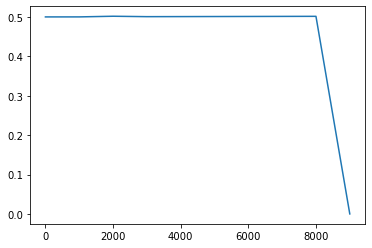

In [22]:
plt.plot(x, H)

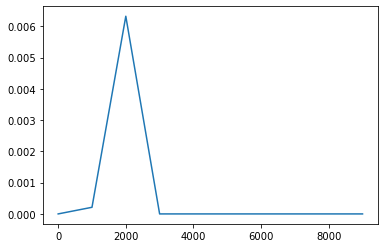

In [13]:
plt.plot(x, ql)

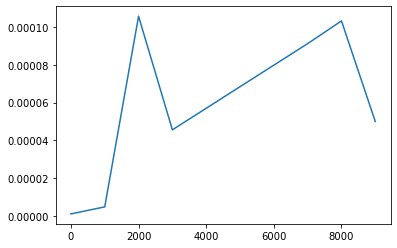

In [14]:
plt.plot(x, E_avg)

In [15]:
E_vals

array([[1.01983419e-06, 6.26305031e-06, 1.47435302e-04, 4.55624543e-05,
        5.69782947e-05, 6.83903859e-05, 7.97985951e-05, 9.12028590e-05,
        1.03576584e-04, 5.00000000e-05],
       [1.01989261e-06, 2.14780383e-06, 3.41757917e-05, 4.56140426e-05,
        5.70529264e-05, 6.84921086e-05, 7.99314555e-05, 9.13709028e-05,
        1.02810416e-04, 5.00000000e-05]])

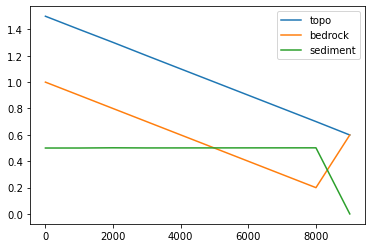

In [16]:
plt.plot(x, eta, label = 'topo')
plt.plot(x, etab, label = 'bedrock')
plt.plot(x, H, label = 'sediment')
plt.legend()

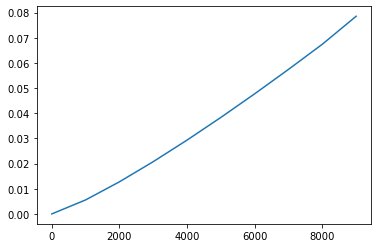

In [17]:
plt.plot(x, Qs)

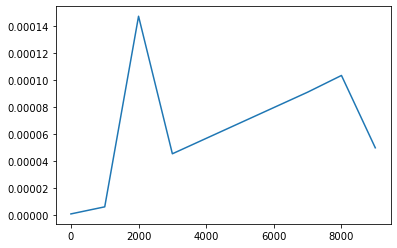

In [18]:
plt.plot(x, E)